__Our challenge is to predict 'FitmentPercent' on test data by predicting the 'BiasInfluentialFactor' first.__

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
#Reading the data into train and test variables
train = pd.read_csv(r'C:\Users\namateti\Downloads\0753aae4bec411eb\Train.csv')
test = pd.read_csv(r'C:\Users\namateti\Downloads\0753aae4bec411eb\Test.csv')

In [3]:
train.shape, test.shape

((13645, 22), (8745, 20))

In [4]:
train.head()

,EmpID,EmpName,LanguageOfCommunication,Age,Gender,JobProfileIDApplyingFor,HighestDegree,DegreeBranch,GraduatingInstitute,LatestDegreeCGPA,...,CurrentCTC,ExpectedCTC,MartialStatus,EmpScore,CurrentDesignation,CurrentCompanyType,DepartmentInCompany,TotalLeavesTaken,BiasInfluentialFactor,FitmentPercent
0,11041,John,English,35,Male,JR85289,B.Tech,Electrical,Tier 1,7,...,21,26,Married,5,SSE,Enterprise,Design,20,YearsOfExperince,95.40
1,15079,William,English,26,Male,JR87525,B.Tech,Artificial Intelligence,Tier 3,7,...,15,19,Married,5,BA,MidSized,Engineering,6,NaN,67.09
2,18638,James,English,36,Female,JR87525,PhD,Computer Science,Tier 1,6,...,15,24,Single,5,SDE,MidSized,Engineering,19,Gender,91.26
3,3941,Charles,English,29,Female,JR87525,BCA,Information Technology,Tier 2,5,...,16,24,Married,5,SDE,Startup,Product,16,Gender,72.29
4,5936,George,English,25,Male,JR70175,Dual M.Tech,Computer Science,Tier 3,8,...,24,32,Married,5,SDE,Enterprise,Engineering,10,DegreeBranch,86.34


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13645 entries, 0 to 13644
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmpID                    13645 non-null  int64  
 1   EmpName                  13645 non-null  object 
 2   LanguageOfCommunication  13645 non-null  object 
 3   Age                      13645 non-null  int64  
 4   Gender                   13645 non-null  object 
 5   JobProfileIDApplyingFor  13645 non-null  object 
 6   HighestDegree            13645 non-null  object 
 7   DegreeBranch             13645 non-null  object 
 8   GraduatingInstitute      13645 non-null  object 
 9   LatestDegreeCGPA         13645 non-null  int64  
 10  YearsOfExperince         13645 non-null  int64  
 11  GraduationYear           13645 non-null  int64  
 12  CurrentCTC               13645 non-null  int64  
 13  ExpectedCTC              13645 non-null  int64  
 14  MartialStatus         

In [6]:
train.isnull().sum()

EmpID                         0
EmpName                       0
LanguageOfCommunication       0
Age                           0
Gender                        0
JobProfileIDApplyingFor       0
HighestDegree                 0
DegreeBranch                  0
GraduatingInstitute           0
LatestDegreeCGPA              0
YearsOfExperince              0
GraduationYear                0
CurrentCTC                    0
ExpectedCTC                   0
MartialStatus                 0
EmpScore                      0
CurrentDesignation            0
CurrentCompanyType            0
DepartmentInCompany           0
TotalLeavesTaken              0
BiasInfluentialFactor      3336
FitmentPercent                0
dtype: int64

In [7]:
test.isnull().sum()

EmpID                      0
EmpName                    0
LanguageOfCommunication    0
Age                        0
Gender                     0
JobProfileIDApplyingFor    0
HighestDegree              0
DegreeBranch               0
GraduatingInstitute        0
LatestDegreeCGPA           0
YearsOfExperince           0
GraduationYear             0
CurrentCTC                 0
ExpectedCTC                0
MartialStatus              0
EmpScore                   0
CurrentDesignation         0
CurrentCompanyType         0
DepartmentInCompany        0
TotalLeavesTaken           0
dtype: int64

__We could see train data has null values in 'BiasInfluentialFactor' column__

In [6]:
train['BiasInfluentialFactor'].value_counts()

DegreeBranch          2858
Gender                2605
YearsOfExperince      1561
CurrentCompanyType    1174
EmpScore               659
HighestDegree          582
Ethinicity             328
MartialStatus          280
LatestDegreeCGPA       262
Name: BiasInfluentialFactor, dtype: int64

__Since it has multiple categories we cannot just impute null values with mode. So imputing with 'Unknown' value.__

In [7]:
train['BiasInfluentialFactor']= train['BiasInfluentialFactor'].fillna('Unknown')

In [8]:
train['BiasInfluentialFactor'].unique()

array(['YearsOfExperince', 'Unknown', 'Gender', 'DegreeBranch',
       'CurrentCompanyType', 'MartialStatus', 'HighestDegree', 'EmpScore',
       'Ethinicity', 'LatestDegreeCGPA'], dtype=object)

#### Now lets check correlation between dependent and independent variables

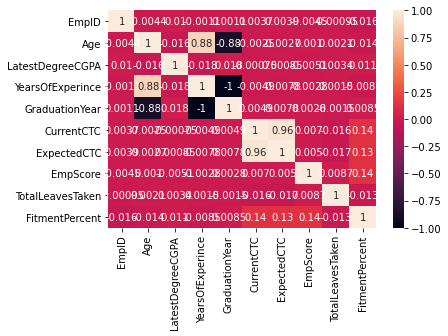

In [9]:
sns.heatmap(train.corr(),annot=True)

We could see that GraduationYear and YearsOfExperince are highly negatively correlated.
Age is highly postively correlated with YearsOfExperince and negatively correlated with GraduationYear.

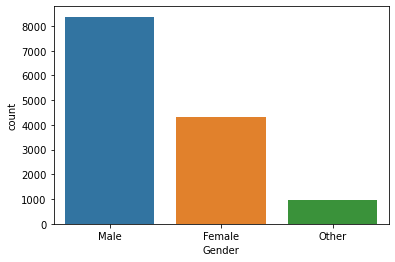

In [10]:
sns.countplot(train['Gender'])

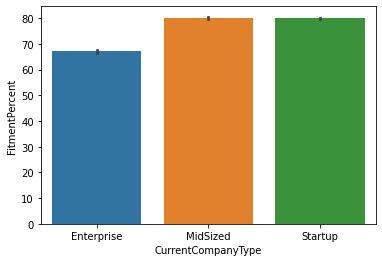

In [11]:
sns.barplot(train['CurrentCompanyType'],train['FitmentPercent'])

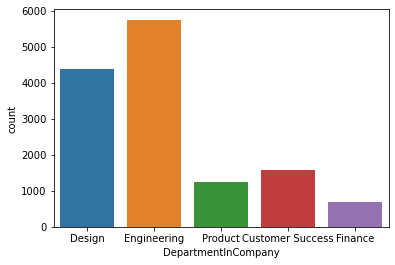

In [13]:
sns.countplot(train['DepartmentInCompany'])

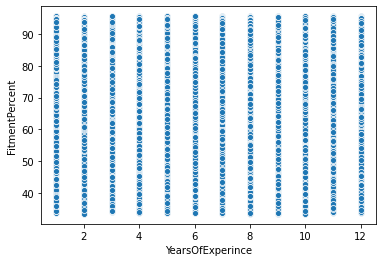

In [15]:
sns.scatterplot(train['YearsOfExperince'],train['FitmentPercent'])

__Lets map 'BiasInfluentialFactor' to int values__ 

In [16]:
mapper = {"YearsOfExperince":1,"Unknown":0,"Gender":2,"DegreeBranch":3,"CurrentCompanyType":4,
              "MartialStatus":5,"HighestDegree":6,"EmpScore":7,"Ethinicity":8,"LatestDegreeCGPA":9}
train['BiasInfluentialFactor'] = train.BiasInfluentialFactor.map(mapper)


In [17]:
#Dropping 'EmpName','EmpID' columns from train and test sets as these are unique and we dont need 
#these variables in order to predict required output.
test_EmpID = test['EmpID']
train = train.drop(columns = ['EmpName','EmpID'], axis=1)
test = test.drop(columns = ['EmpName','EmpID'], axis=1)

In [18]:
# Labelencoding all categorical variables.
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
var_mod = train.select_dtypes(include='object').columns
for i in var_mod:
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])
    

## Predicting the 'BiasInfluentialFactor' first using LGBMclassifier

In [19]:
X= train.drop(columns = ['BiasInfluentialFactor','FitmentPercent'], axis=1)
y= train['BiasInfluentialFactor']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42,stratify = y)

In [21]:
model =LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=30,
    max_depth=7,
    learning_rate=0.1,
    n_estimators=150,
    subsample_for_bin=200000,
    objective=None,
    class_weight=None,
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=20,
    subsample=1.0,
    subsample_freq=0,
    colsample_bytree=1.0,
    reg_alpha=0.0,
    reg_lambda=0.0,
    random_state=42,
    n_jobs=-1,
    silent=True,
    importance_type='split'
)

In [22]:
model.fit(X_train,y_train)

LGBMClassifier(max_depth=7, n_estimators=150, num_leaves=30, random_state=42)

In [23]:
predictions = model.predict(X_test)

In [24]:
roc_auc_score(y_test, model.predict_proba(X_test),multi_class='ovr')

0.9626116768793217

In [25]:
df1 = pd.DataFrame(
    {
        'act_bias':y_test,
        'pred_bias':predictions
    }
)

In [26]:
# We could see the model is predicting well.
print(df1)

       act_bias  pred_bias
8784          0          0
3463          1          1
10197         4          0
2118          1          1
2386          2          2
...         ...        ...
7229          6          6
11626         7          7
4761          0          0
1688          0          0
3279          3          3

[4094 rows x 2 columns]


In [27]:
confusion_matrix(df1['act_bias'],df1['pred_bias'])

array([[680,  64,  70,  66,  66,  18,   9,  15,   9,   4],
       [ 18, 444,   0,   0,   6,   0,   0,   0,   0,   0],
       [  4,   0, 764,   0,  10,   0,   0,   0,   0,   4],
       [ 53,   0,   0, 795,   7,   0,   0,   0,   0,   2],
       [161,  15,  46,   5, 122,   0,   0,   0,   0,   3],
       [ 23,   0,   0,   0,   0,  47,   0,   0,   7,   7],
       [  7,   0,   0,   0,   0,   0, 167,   0,   0,   1],
       [  9,   0,   0,   0,   0,   0,   0, 176,  13,   0],
       [ 35,   0,   0,   0,   0,  16,   0,  38,   6,   3],
       [ 14,   4,  16,   7,  11,   2,   1,   0,   2,  22]], dtype=int64)

It still has some miss-classification. We can reduce these errors by doing feature-engineering,outlier removals,feature selection.

In [28]:
model.fit(X,y)

LGBMClassifier(max_depth=7, n_estimators=150, num_leaves=30, random_state=42)

In [29]:
preds = model.predict_proba(test)

In [30]:
list_test = []
for j,i in enumerate(list(preds)):
    ind = np.where(i==max(i))[0][0]
    list_test.append(ind)
    
test['BiasInfluentialFactor'] = list_test


## Predicting the 'FitmentPercent' first using LGBMRegressor

In [31]:
new_X= train.drop(columns = ['FitmentPercent'], axis=1)
new_y= train['FitmentPercent']

In [32]:
new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.20, random_state=42,stratify = y)

In [33]:
from lightgbm import LGBMRegressor
model2 = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=8,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42

)

In [34]:
model2.fit(new_X_train,new_y_train)

LGBMRegressor(max_depth=8, random_state=42)

In [35]:
preds2 = model2.predict(new_X_test)

In [36]:
# for i in range(len(preds2)):
#     preds2[i] = np.round(preds2[i],2)
#     print(preds2[i])

In [37]:
df2 = pd.DataFrame(
    {
        'act_bias':new_y_test,
        'pred_bias':preds2
    }
)

In [39]:
#To ensure that our model is predicting well, rmse should be low. Lower the RMSE, Better the model.
from sklearn.metrics import mean_squared_error

errors = (mean_squared_error(df2['act_bias'], 
                             df2['pred_bias']))**0.5
errors

6.642221440294863

In [40]:
model2.fit(new_X,new_y)

LGBMRegressor(max_depth=8, random_state=42)

In [41]:
final_pred = model2.predict(test)

__Since in the sample submission model is 'BiasInfluentialFactor' is not encoded, lets map it back to original format.__

In [42]:
mapper = {1:"YearsOfExperince",0:np.nan,2:"Gender",3:"DegreeBranch",4:"CurrentCompanyType",
              5:"MartialStatus",6:"HighestDegree",7:"EmpScore",8:"Ethinicity",9:"LatestDegreeCGPA"}
test['BiasInfluentialFactor'] = test.BiasInfluentialFactor.map(mapper)

In [43]:
final_df = pd.DataFrame(
    {
            'EmpID' : test_EmpID,
            'BiasInfluentialFactor' : test['BiasInfluentialFactor'],
            'FitmentPercent' : final_pred
    }

)

In [43]:
final_df.to_csv(r'C:\Users\namateti\Downloads\0753aae4bec411eb\final_df.csv',index=False)

## Update:
Since the score on the hackerearth for the final_df is 99.98, I'm submitting the same model.
If the score would have been less we could still try different techniques(like feature-engineering,outlier removals,feature selection) to make the model better. But with the current score, I can assume my model is working better to make predictions on target variable.